# Metodo dei Minimi Quadrati per la stazione di Pian di Fedaia (diga)

## Consiste nel minimizzare lo scarto quadratico medio tra ECDF e la probabilità di non superamento

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import least_squares
from statsmodels.distributions.empirical_distribution import ECDF

from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
import numpy as np
from pylab import plot, show, hist,figure, title

In [2]:
os_DatiFedaia=os.getcwd()
os.chdir(os_DatiFedaia)

In [3]:
data=pd.read_csv('DatiFedaiaSub.csv')
map(datetime,data['Anno'])
data=data.set_index('Anno')

#### Lista contenente le durate temporali

In [4]:
h=[]
for i in range(len(data.columns)):
    h.append(data.columns[i])

### Si definisce lo Scarto Quadratico Medio
#### ovvero la differenza tra ECDF e probabilità di non superamento

In [5]:
def fun(x, t, y):
    return np.exp(-np.exp(-(t-x[0])/x[1]))-y

### Si crea un dizionario delle misure di ECDF che usa come chiavi gli intervalli orari

In [6]:
ecdf={}
for i in h:
    ecdf.update({i:ECDF(data[i].dropna())})

### Si prendono come parametri di riferimento quelli calcolati con il metodo dei Momenti

In [7]:
x0=pd.read_pickle('abs_m')

### Si calcolano i parametri con il metodo dei minimi quadrati

In [8]:
res_lsq=[]
for i in h:    
    t_rain=sorted(data[i].dropna())                        
    y_rain=ecdf[i](t_rain) #misure di ECDF
    res_lsq_=least_squares(fun,x0[i], args=(t_rain,y_rain)) #least_squares chiede come input una funzione, x0 iniziale e gli argomenti da mettere in funzione
    res_lsq.append(res_lsq_.x)
    
abs_mq=pd.DataFrame(res_lsq,columns=["a","b"],index=h).T

### Così si crea un file dove sono salvati i parametri appena calcolati

In [9]:
abs_mq.to_pickle('abs_mq')

#### Si divide per le varie fasce temporali

In [10]:
abs_=abs_mq.T
abs_min=abs_[:3]
abs_ore=abs_[3:8]
abs_gg=abs_[8:]

### Operazioni preliminari per poter graficare i risultati

#### Definire la funzione delle curve di Gumbel

In [11]:
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))

#### Definire lo spazio lineare dove graficare i risultati lungo l'ascissa

In [12]:
def t_rain(df):   
    minimo=min(df.min()) #7.2 per le durate orarie! 
    mass=max(df.max()) #132.6 per le orarie!
    mass=mass+mass*1.5

    return np.linspace(minimo,mass,100) #t_rain

#### Funzione che crea un dataframe contenente i valori delle curve di Gumbel

In [13]:
def bbb(t_r,abs_a):
    g=[]
    h=[]
    for i in range(len(abs_a.columns)):
        h.append(abs_a.columns[i])
    for i in h:
        g.append(gumbel(t_r,abs_a,i))
    
    gb=pd.DataFrame(g).T
    gb.index=t_r
    gb.columns=h
    return gb

### Si impostano i grafici

In [14]:
import random
colors={}
c=[]
for i in h:
    colore=(random.random(), random.random(), random.random())
    colors.update({i:colore})
    c.append(colors[i])
    
c_min=c[:3]
c_ore=c[3:8]
c_gg=c[8:]

In [15]:
XSMALL_SIZE=2
SMALL_SIZE=10
MEDIUM_SIZE=20
BIGGER_SIZE=30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     #fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=XSMALL_SIZE)

In [16]:
def grafG_E(df,title,x_label,y_label,leg_label,cx):
    T=t_rain(df.T)
    gb=bbb(T,df)
    ax=gb.plot(figsize=(18,10),color=cx)
    
    ecdf={}
    h=[]
    for i in range(len(df.columns)):
        h.append(df.columns[i])
    for i in h:
        ecdf.update({i:ECDF(data[i].dropna())})
        ax.plot(data[i].dropna(),ecdf[i](data[i].dropna()),'o',c=colors[i])
        
    ax.set_title(title,size=MEDIUM_SIZE)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True,color='whitesmoke')
    ax.legend (title= leg_label, loc=4, fontsize=MEDIUM_SIZE, title_fontsize=MEDIUM_SIZE)

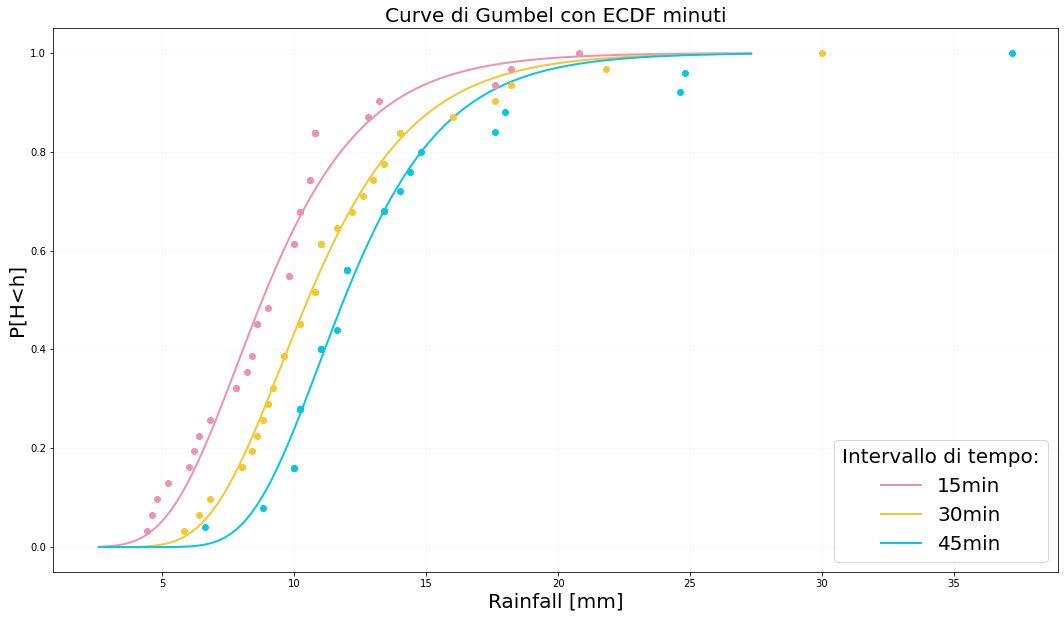

In [17]:
grafG_E(abs_min.T,'Curve di Gumbel con ECDF minuti','Rainfall [mm]','P[H<h]',"Intervallo di tempo:",c_min)

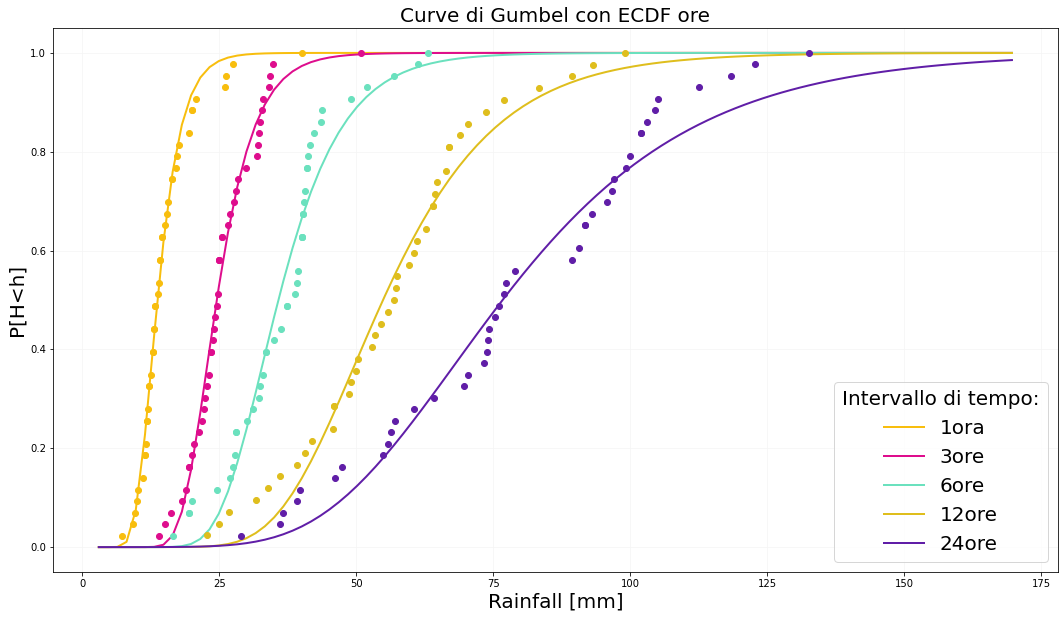

In [18]:
grafG_E(abs_ore.T,'Curve di Gumbel con ECDF ore','Rainfall [mm]','P[H<h]',"Intervallo di tempo:",c_ore)

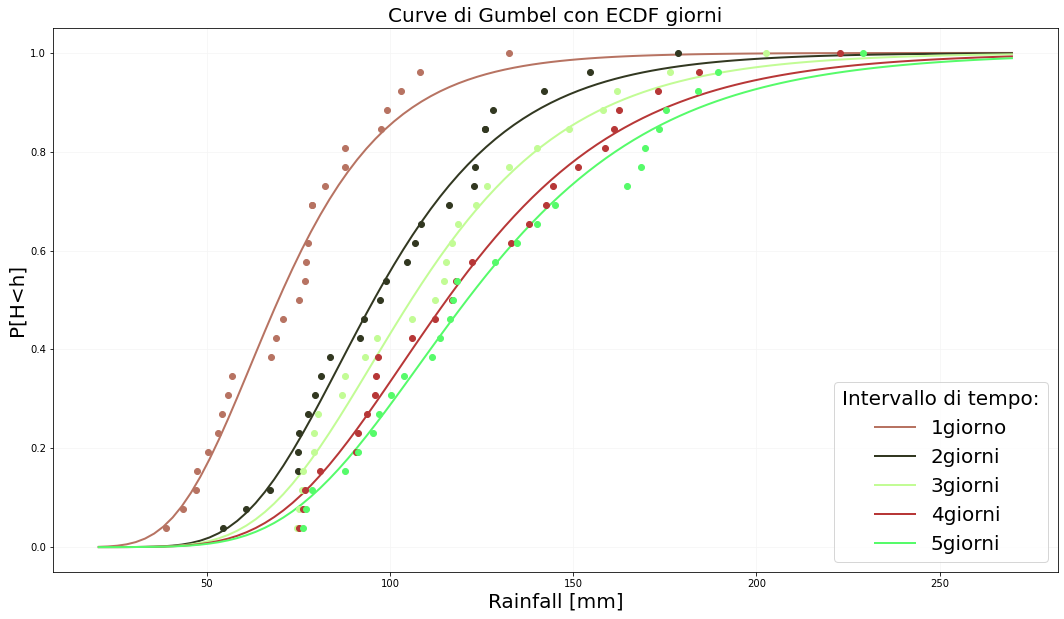

In [19]:
grafG_E(abs_gg.T,'Curve di Gumbel con ECDF giorni','Rainfall [mm]','P[H<h]',"Intervallo di tempo:",c_gg)